In [30]:
import os
import json
import csv
from datetime import datetime


def extract_f1_scores(dashboard_dir, output_csv):
    """
    Traverse the dashboard directory, extract macro avg F1 scores from JSON files,
    and save to a CSV file along with relevant metadata.

    Parameters:
        dashboard_dir (str): Base directory containing the structured dashboard outputs.
        output_csv (str): Path to save the resulting CSV file.
    """
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    # Open the CSV file for writing
    with open(output_csv, mode="w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)

        # Write CSV header
        csv_writer.writerow(
            [
                "timestamp",
                "model_name",
                "layer",
                "width",
                "type",
                "dataset_name",
                "dataset_split",
                "linear_macro_f1_score",
                "linear_accuracy",
                "linear_mean_cv_accuracy",
                "linear_std_cv_accuracy",
                "decision_tree_macro_f1_score",
                "decision_tree_accuracy",
                "decision_tree_mean_cv_accuracy",
                "decision_tree_std_cv_accuracy",
            ]
        )

        # Traverse the dashboard directory
        for root, _, files in os.walk(dashboard_dir):
            for file in files:
                if file.endswith(".json"):
                    json_path = os.path.join(root, file)

                    try:
                        # Load the JSON file
                        with open(json_path, "r") as f:
                            data = json.load(f)

                        # Extract metadata
                        metadata = data.get("metadata", {})
                        models = data.get("models", {})

                        timestamp = metadata.get("timestamp", "N/A")
                        model_name = metadata.get("model", {}).get("name", "N/A")
                        layer = metadata.get("model", {}).get("layer", "N/A")
                        width = metadata.get("args", {}).get("width", "N/A")
                        dataset_name = metadata.get("dataset", {}).get("name", "N/A")
                        dataset_split = metadata.get("args", {}).get(
                            "dataset_split", "N/A"
                        )
                        hidden = metadata.get("dataset", {}).get("hidden", "N/A")

                        if hidden:
                            hidden_value = "Hidden States"
                        else:
                            hidden_value = "SAE Features"

                        # Extract Linear Probe metrics
                        linear_probe = models.get("linearProbe", {})
                        linear_macro_avg = linear_probe.get(
                            "aggregated_metrics", {}
                        ).get("macro avg", {})
                        linear_f1_score = linear_macro_avg.get("f1_score", "N/A")

                        linear_performance = linear_probe.get("performance", {})
                        linear_accuracy = linear_performance.get("accuracy", "N/A")
                        linear_cv = linear_performance.get("cross_validation", {})
                        linear_mean_cv_accuracy = linear_cv.get("mean_accuracy", "N/A")
                        linear_std_cv_accuracy = linear_cv.get("std_accuracy", "N/A")

                        # Extract Decision Tree metrics
                        decision_tree = models.get("decisionTree", {})
                        decision_tree_macro_avg = decision_tree.get(
                            "aggregated_metrics", {}
                        ).get("macro avg", {})
                        decision_tree_f1_score = decision_tree_macro_avg.get(
                            "f1_score", "N/A"
                        )

                        decision_tree_performance = decision_tree.get("performance", {})
                        decision_tree_accuracy = decision_tree_performance.get(
                            "accuracy", "N/A"
                        )
                        decision_tree_cv = decision_tree_performance.get(
                            "cross_validation", {}
                        )
                        decision_tree_mean_cv_accuracy = decision_tree_cv.get(
                            "mean_accuracy", "N/A"
                        )
                        decision_tree_std_cv_accuracy = decision_tree_cv.get(
                            "std_accuracy", "N/A"
                        )

                        # Append extracted data to CSV
                        csv_writer.writerow(
                            [
                                timestamp,
                                model_name,
                                layer,
                                width,
                                hidden_value,
                                dataset_name,
                                dataset_split,
                                linear_f1_score,
                                linear_accuracy,
                                linear_mean_cv_accuracy,
                                linear_std_cv_accuracy,
                                decision_tree_f1_score,
                                decision_tree_accuracy,
                                decision_tree_mean_cv_accuracy,
                                decision_tree_std_cv_accuracy,
                            ]
                        )

                        print(f"Processed: {json_path}")

                    except Exception as e:
                        print(f"Error processing {json_path}: {e}")

    print(f"Extraction complete. Results saved to {output_csv}")


# Example usage
if __name__ == "__main__":
    dashboard_dir = "../dashboard_data/"  # Replace with your dashboard directory
    output_csv = "./macro_f1_scores.csv"  # Replace with your desired CSV output file
    extract_f1_scores(dashboard_dir, output_csv)

Processed: ../dashboard_data/google_gemma-2-9b-it/Anthropic_election_questions/layer_9/16k/20241122_161048/hidden_classifier_results.json
Processed: ../dashboard_data/google_gemma-2-9b-it/Anthropic_election_questions/layer_9/16k/20241122_161048/sae_classifier_results.json
Processed: ../dashboard_data/google_gemma-2-9b-it/Anthropic_election_questions/layer_31/16k/20241122_161250/hidden_classifier_results.json
Processed: ../dashboard_data/google_gemma-2-9b-it/Anthropic_election_questions/layer_31/16k/20241122_161250/sae_classifier_results.json
Processed: ../dashboard_data/google_gemma-2-9b-it/Anthropic_election_questions/layer_20/16k/20241122_161144/hidden_classifier_results.json
Processed: ../dashboard_data/google_gemma-2-9b-it/Anthropic_election_questions/layer_20/16k/20241122_161144/sae_classifier_results.json
Processed: ../dashboard_data/google_gemma-2-9b-it/jackhhao_jailbreak-classification/layer_9/16k/20241122_203247/hidden_classifier_results.json
Processed: ../dashboard_data/googl

In [31]:
import pandas as pd

pd.read_csv(output_csv)

,timestamp,model_name,layer,width,type,dataset_name,dataset_split,linear_macro_f1_score,linear_accuracy,linear_mean_cv_accuracy,linear_std_cv_accuracy,decision_tree_macro_f1_score,decision_tree_accuracy,decision_tree_mean_cv_accuracy,decision_tree_std_cv_accuracy
0,2024-11-22T16:10:48.729801,google/gemma-2-9b-it,9,16k,Hidden States,Anthropic/election_questions,test,0.973124,0.973154,0.981484,0.013442,0.879058,0.879195,0.893975,0.025700
1,2024-11-22T16:10:48.734285,google/gemma-2-9b-it,9,16k,SAE Features,Anthropic/election_questions,test,0.966419,0.966443,0.983179,0.011874,0.926055,0.926174,0.914115,0.033440
2,2024-11-22T16:12:50.360680,google/gemma-2-9b-it,31,16k,Hidden States,Anthropic/election_questions,test,0.966419,0.966443,0.981456,0.013510,0.905832,0.906040,0.895656,0.021523
3,2024-11-22T16:12:50.365537,google/gemma-2-9b-it,31,16k,SAE Features,Anthropic/election_questions,test,0.993284,0.993289,0.983179,0.011874,0.885824,0.885906,0.932673,0.005159
4,2024-11-22T16:11:44.171508,google/gemma-2-9b-it,20,16k,Hidden States,Anthropic/election_questions,test,1.000000,1.000000,0.991582,0.005315,0.932859,0.932886,0.931007,0.023342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2024-11-21T21:05:21.836543,google/gemma-2-2b,5,65k,SAE Features,AIM-Harvard/reject_prompts,train,0.995968,0.995968,0.993960,0.008045,0.983870,0.983871,0.979849,0.006348
144,2024-11-21T20:23:20.698126,google/gemma-2-2b,19,16k,Hidden States,AIM-Harvard/reject_prompts,train,1.000000,1.000000,0.996970,0.002474,0.959675,0.959677,0.954611,0.018935
145,2024-11-21T20:23:20.701564,google/gemma-2-2b,19,16k,SAE Features,AIM-Harvard/reject_prompts,train,0.987903,0.987903,0.995975,0.003762,0.947539,0.947581,0.963728,0.009709
146,2024-11-21T21:11:58.867574,google/gemma-2-2b,19,65k,Hidden States,AIM-Harvard/reject_prompts,train,0.991935,0.991935,1.000000,0.000000,0.963709,0.963710,0.941531,0.008176


In [32]:
# filter to model_name= google/gemma-2-9b and layer= 31
df = pd.read_csv(output_csv)
df = df[(df["model_name"] == "google/gemma-2-9b") & (df["layer"] == 31)]
df

,timestamp,model_name,layer,width,type,dataset_name,dataset_split,linear_macro_f1_score,linear_accuracy,linear_mean_cv_accuracy,linear_std_cv_accuracy,decision_tree_macro_f1_score,decision_tree_accuracy,decision_tree_mean_cv_accuracy,decision_tree_std_cv_accuracy
26,2024-11-22T18:20:47.914674,google/gemma-2-9b,31,16k,Hidden States,Anthropic/election_questions,test,0.979862,0.979866,0.994958,0.006723,0.859060,0.859060,0.939353,0.018133
27,2024-11-22T18:20:47.918898,google/gemma-2-9b,31,16k,SAE Features,Anthropic/election_questions,test,0.973153,0.973154,0.974776,0.011864,0.946306,0.946309,0.949480,0.017676
28,2024-11-22T16:51:05.537192,google/gemma-2-9b,31,16k,Hidden States,Anthropic/election_questions,test,0.986572,0.986577,0.991597,0.007516,0.892380,0.892617,0.924213,0.026675
29,2024-11-22T16:51:05.542137,google/gemma-2-9b,31,16k,SAE Features,Anthropic/election_questions,test,0.973095,0.973154,0.971400,0.008531,0.946190,0.946309,0.941105,0.011784
34,2024-11-22T20:38:11.474223,google/gemma-2-9b,31,16k,Hidden States,jackhhao/jailbreak-classification,test,1.000000,1.000000,0.966318,0.029041,0.866210,0.867925,0.774913,0.045321
35,2024-11-22T20:38:11.479245,google/gemma-2-9b,31,16k,SAE Features,jackhhao/jailbreak-classification,test,0.920557,0.921053,0.979770,0.026785,0.893557,0.894737,0.933103,0.029560
40,2024-11-22T17:23:51.673490,google/gemma-2-9b,31,16k,Hidden States,textdetox/multilingual_toxicity_dataset,en,0.962000,0.962000,0.952250,0.006093,0.833967,0.834000,0.837500,0.012425
41,2024-11-22T17:23:51.678407,google/gemma-2-9b,31,16k,SAE Features,textdetox/multilingual_toxicity_dataset,en,0.954987,0.955000,0.965250,0.003984,0.936992,0.937000,0.931000,0.007802
46,2024-11-22T20:29:23.639445,google/gemma-2-9b,31,16k,Hidden States,AIM-Harvard/reject_prompts,train,1.000000,1.000000,0.998990,0.002020,0.939492,0.939516,0.939516,0.014952
47,2024-11-22T20:29:23.643782,google/gemma-2-9b,31,16k,SAE Features,AIM-Harvard/reject_prompts,train,0.987901,0.987903,0.994955,0.003194,0.987903,0.987903,0.965687,0.016106


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

raw_df = pd.read_csv(output_csv)

# Group by relevant fields to compute mean scores
grouped_df = (
    raw_df.groupby(
        ["model_name", "layer", "width", "type", "dataset_name", "dataset_split"]
    )
    .agg(
        {
            "linear_macro_f1_score": "mean",
            "linear_accuracy": "mean",
            "linear_mean_cv_accuracy": "mean",
            "linear_std_cv_accuracy": "mean",
            "decision_tree_macro_f1_score": "mean",
            "decision_tree_accuracy": "mean",
            "decision_tree_mean_cv_accuracy": "mean",
            "decision_tree_std_cv_accuracy": "mean",
        }
    )
    .reset_index()
)

# Pivot the data to separate SAE Features and Hidden States
merged_df = grouped_df.pivot(
    index=["model_name", "layer", "width", "dataset_name", "dataset_split"],
    columns="type",
    values=[
        "linear_macro_f1_score",
        "linear_accuracy",
        "linear_mean_cv_accuracy",
        "linear_std_cv_accuracy",
        "decision_tree_macro_f1_score",
        "decision_tree_accuracy",
        "decision_tree_mean_cv_accuracy",
        "decision_tree_std_cv_accuracy",
    ],
)

# Flatten the MultiIndex columns
merged_df.columns = ["_".join(col).strip() for col in merged_df.columns.values]
merged_df = merged_df.reset_index()

# Preview the merged DataFrame
print(merged_df.head())

          model_name  layer width                             dataset_name  \
0  google/gemma-2-2b      5   16k               AIM-Harvard/reject_prompts   
1  google/gemma-2-2b      5   16k             Anthropic/election_questions   
2  google/gemma-2-2b      5   16k        jackhhao/jailbreak-classification   
3  google/gemma-2-2b      5   16k  textdetox/multilingual_toxicity_dataset   
4  google/gemma-2-2b      5   65k               AIM-Harvard/reject_prompts   

  dataset_split  linear_macro_f1_score_Hidden States  \
0         train                             0.983867   
1          test                             0.966346   
2          test                             0.884783   
3            en                             0.917967   
4         train                             0.991935   

   linear_macro_f1_score_SAE Features  linear_accuracy_Hidden States  \
0                            0.991935                       0.983871   
1                            0.939499             

/tmp/ipykernel_368956/2632681055.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


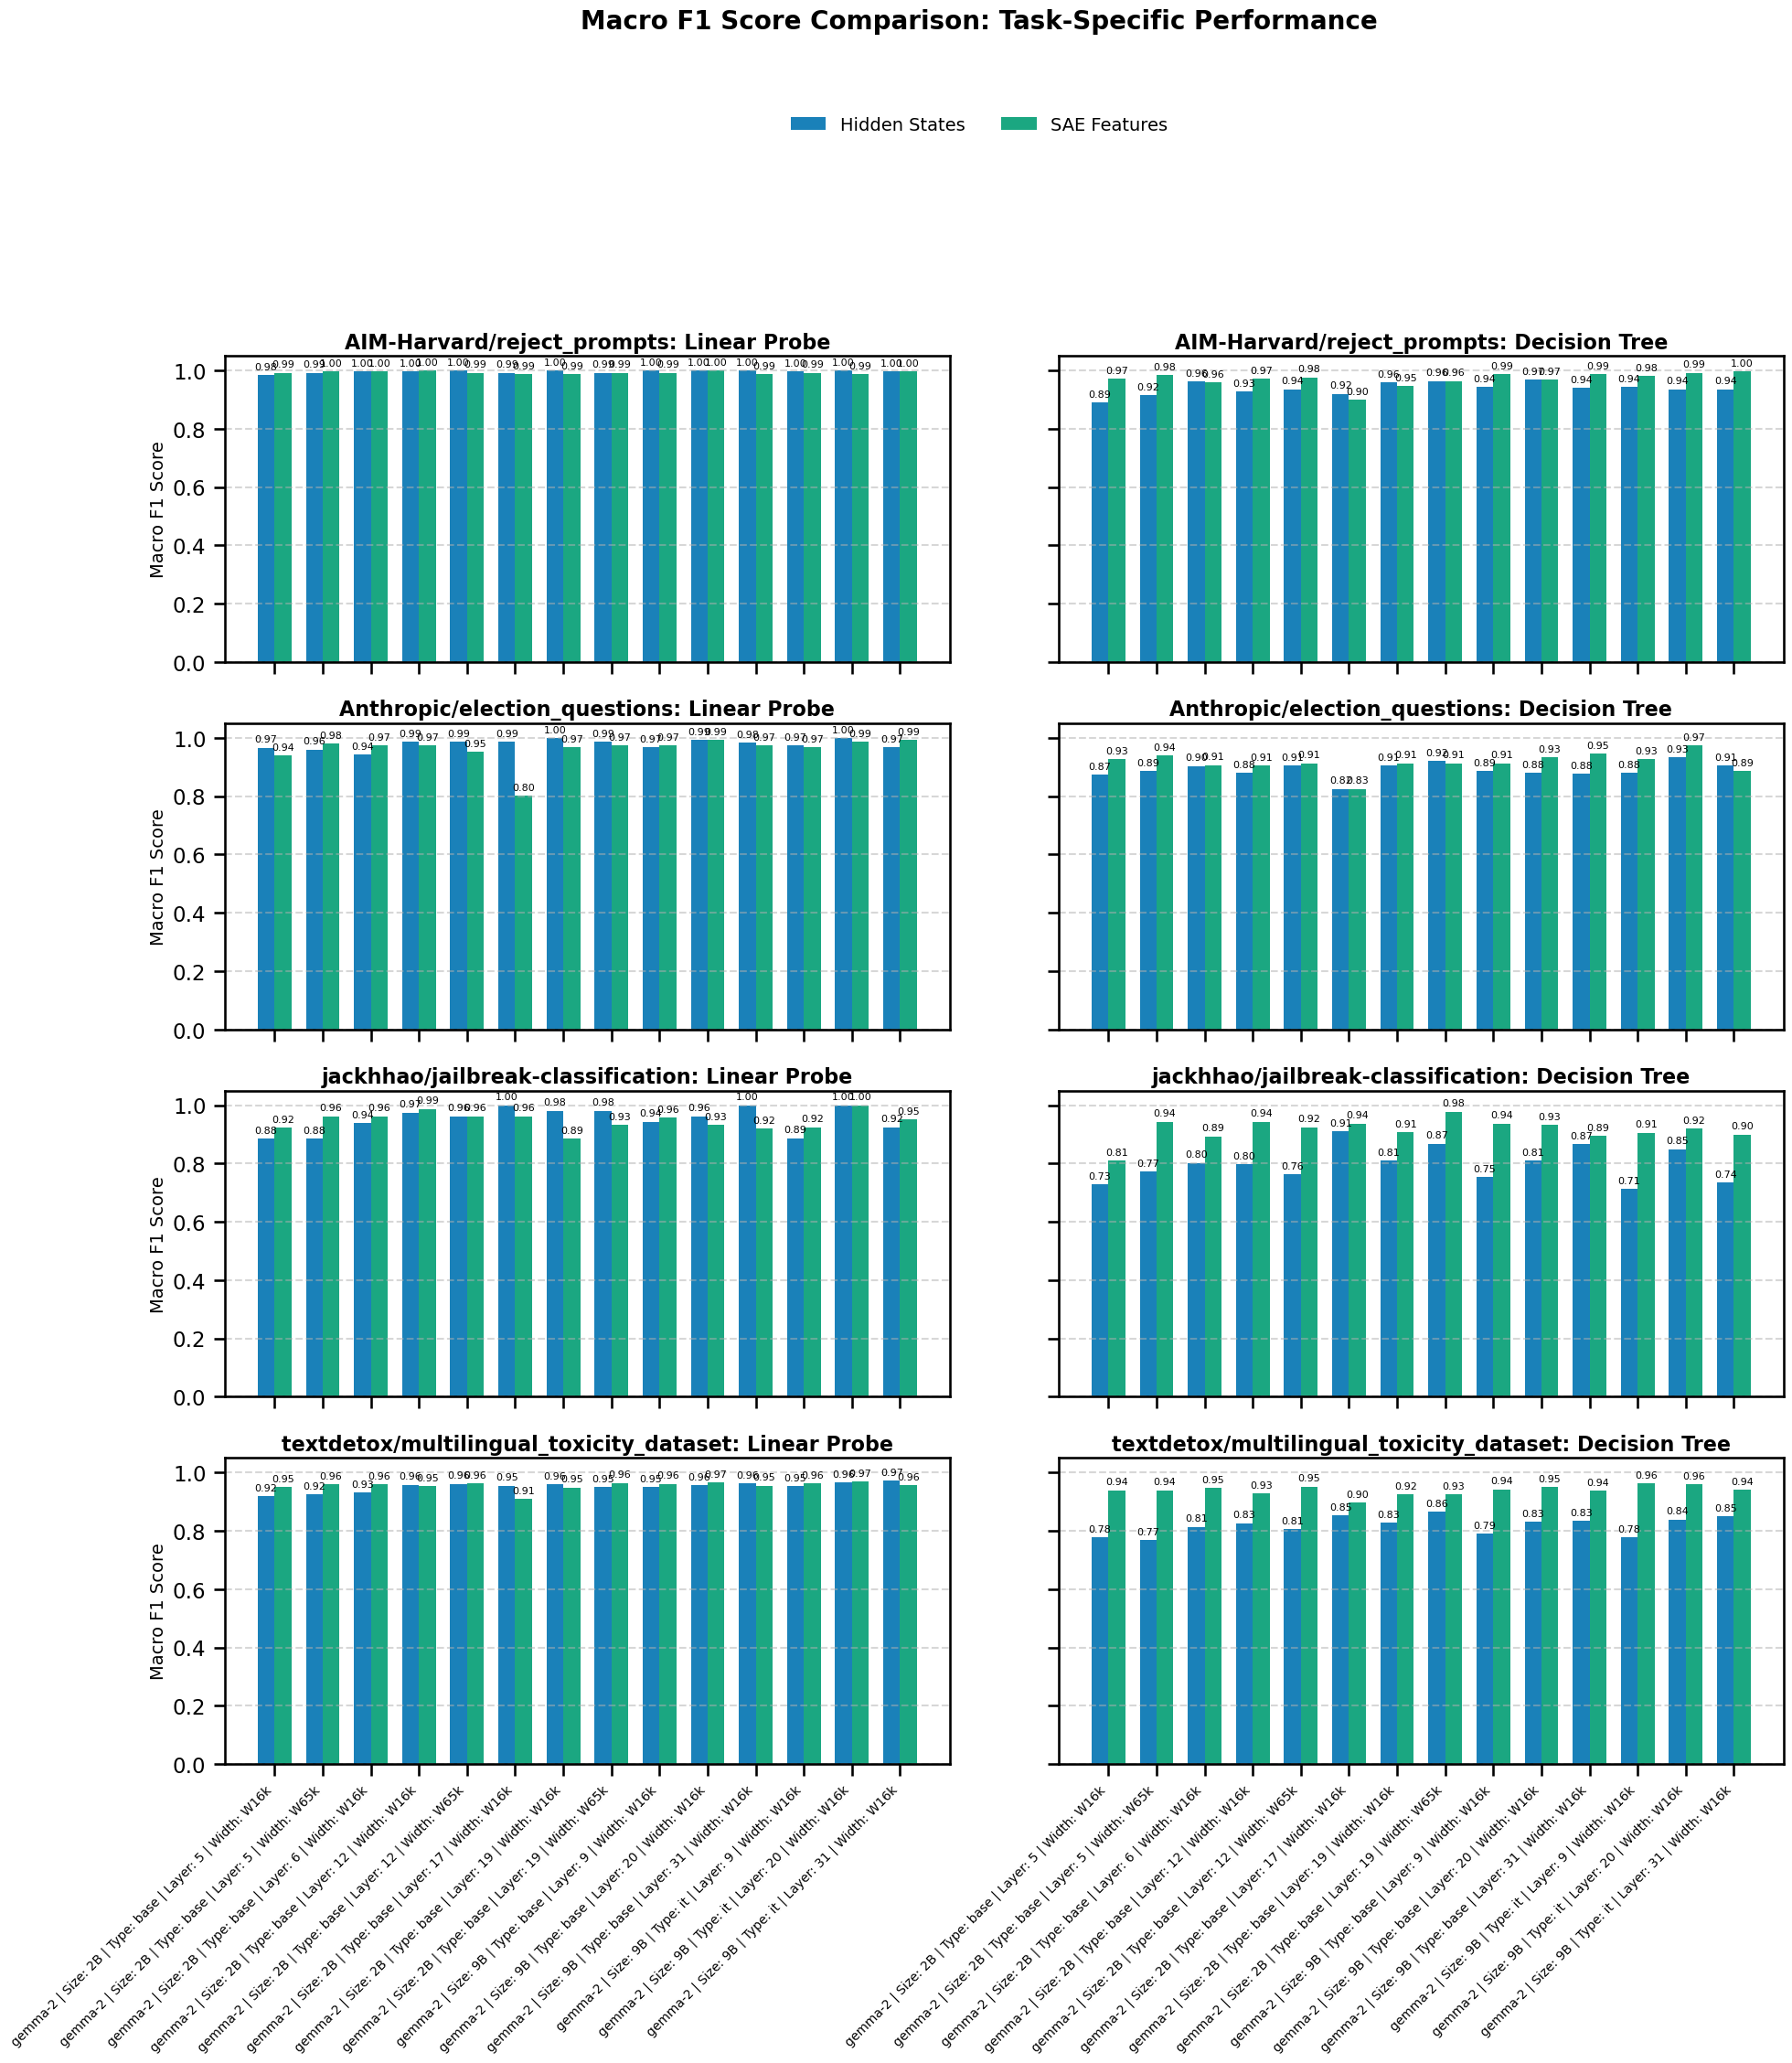

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style for NeurIPS-quality
plt.style.use("seaborn-v0_8-paper")
sns.set_context("talk")  # Adjusts font sizes to be publication-quality

# Use colorblind-friendly palette
colors = sns.color_palette("colorblind")


# Function to extract components
def extract_components(model_name):
    parts = model_name.split("/")
    model_part = parts[1]

    if "gemma-2" in model_part:
        model = "gemma-2"
    else:
        model = "gemma"

    if "2b" in model_part:
        size = 2
    elif "9b" in model_part:
        size = 9
    else:
        size = None

    if "it" in model_part:
        model_type = "it"
    else:
        model_type = "base"

    return model, size, model_type


# Apply the function to create new columns
merged_df[["model", "size", "type"]] = merged_df["model_name"].apply(
    lambda x: pd.Series(extract_components(x))
)

# Sort merged_df by model, size (as a numeric value), type, layer, and width
merged_df_sorted = merged_df.sort_values(by=["model", "size", "type", "layer", "width"])

# Unique x-axis labels with improved format (sorted)
settings = merged_df_sorted.apply(
    lambda row: f"{row['model']} | Size: {row['size']}B | Type: {row['type']} | Layer: {row['layer']} | Width: W{row['width']}",
    axis=1,
).unique()
x = np.arange(len(settings))

# Define colors for the bars
colors_hidden = colors[0]
colors_sae = colors[2]

# Group the data by tasks (e.g., datasets/models)
tasks = merged_df_sorted["dataset_name"].unique()
n_tasks = len(tasks)

# Create a figure with two subplots for each task
fig, axes = plt.subplots(
    n_tasks,
    2,
    figsize=(22, 5 * n_tasks),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.15},
)


# Function to add value labels to bars
def autolabel(ax, rects, fontsize=10):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height > 0:  # Annotate only non-zero values
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=fontsize,
            )


# Loop through tasks
for i, task in enumerate(tasks):
    task_df = merged_df_sorted[merged_df_sorted["dataset_name"] == task]

    # Generate task-specific x indices using the updated settings format
    task_x = [
        list(settings).index(
            f"{row['model']} | Size: {row['size']}B | Type: {row['type']} | Layer: {row['layer']} | Width: W{row['width']}"
        )
        for _, row in task_df.iterrows()
    ]

    # Linear Probe Performance
    ax1 = axes[i, 0]
    probe_hidden = np.zeros(len(settings))  # Default to zero for missing entries
    probe_sae = np.zeros(len(settings))
    probe_hidden[task_x] = (
        task_df["linear_macro_f1_score_Hidden States"].fillna(0).values
    )
    probe_sae[task_x] = task_df["linear_macro_f1_score_SAE Features"].fillna(0).values

    rects1 = ax1.bar(
        x - 0.35 / 2,
        probe_hidden,
        0.35,
        label="Hidden States",
        color=colors_hidden,
        alpha=0.9,
    )
    rects2 = ax1.bar(
        x + 0.35 / 2, probe_sae, 0.35, label="SAE Features", color=colors_sae, alpha=0.9
    )
    autolabel(ax1, rects1, fontsize=8)
    autolabel(ax1, rects2, fontsize=8)

    ax1.set_title(f"{task}: Linear Probe", fontsize=16, weight="bold")
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    ax1.set_ylabel("Macro F1 Score", fontsize=14)

    # Decision Tree Performance
    ax2 = axes[i, 1]
    tree_hidden = np.zeros(len(settings))
    tree_sae = np.zeros(len(settings))
    tree_hidden[task_x] = (
        task_df["decision_tree_macro_f1_score_Hidden States"].fillna(0).values
    )
    tree_sae[task_x] = (
        task_df["decision_tree_macro_f1_score_SAE Features"].fillna(0).values
    )

    rects3 = ax2.bar(
        x - 0.35 / 2,
        tree_hidden,
        0.35,
        label="Hidden States",
        color=colors_hidden,
        alpha=0.9,
    )
    rects4 = ax2.bar(
        x + 0.35 / 2, tree_sae, 0.35, label="SAE Features", color=colors_sae, alpha=0.9
    )
    autolabel(ax2, rects3, fontsize=8)
    autolabel(ax2, rects4, fontsize=8)

    ax2.set_title(f"{task}: Decision Tree", fontsize=16, weight="bold")
    ax2.grid(axis="y", linestyle="--", alpha=0.5)

# Add x-axis labels to the last row
for ax in axes[-1, :]:
    ax.set_xticks(x)
    ax.set_xticklabels(
        settings, rotation=45, ha="right", fontsize=10
    )  # Adjusted rotation and alignment

# Add a single legend to the figure (above the plots)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    fontsize=14,
    frameon=False,
)

# Add overall title and adjust layout
fig.suptitle(
    "Macro F1 Score Comparison: Task-Specific Performance",
    fontsize=20,
    weight="bold",
    y=1.07,
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig("task_f1_comparison.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

/tmp/ipykernel_368956/3279189142.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.04, 1, 0.95])


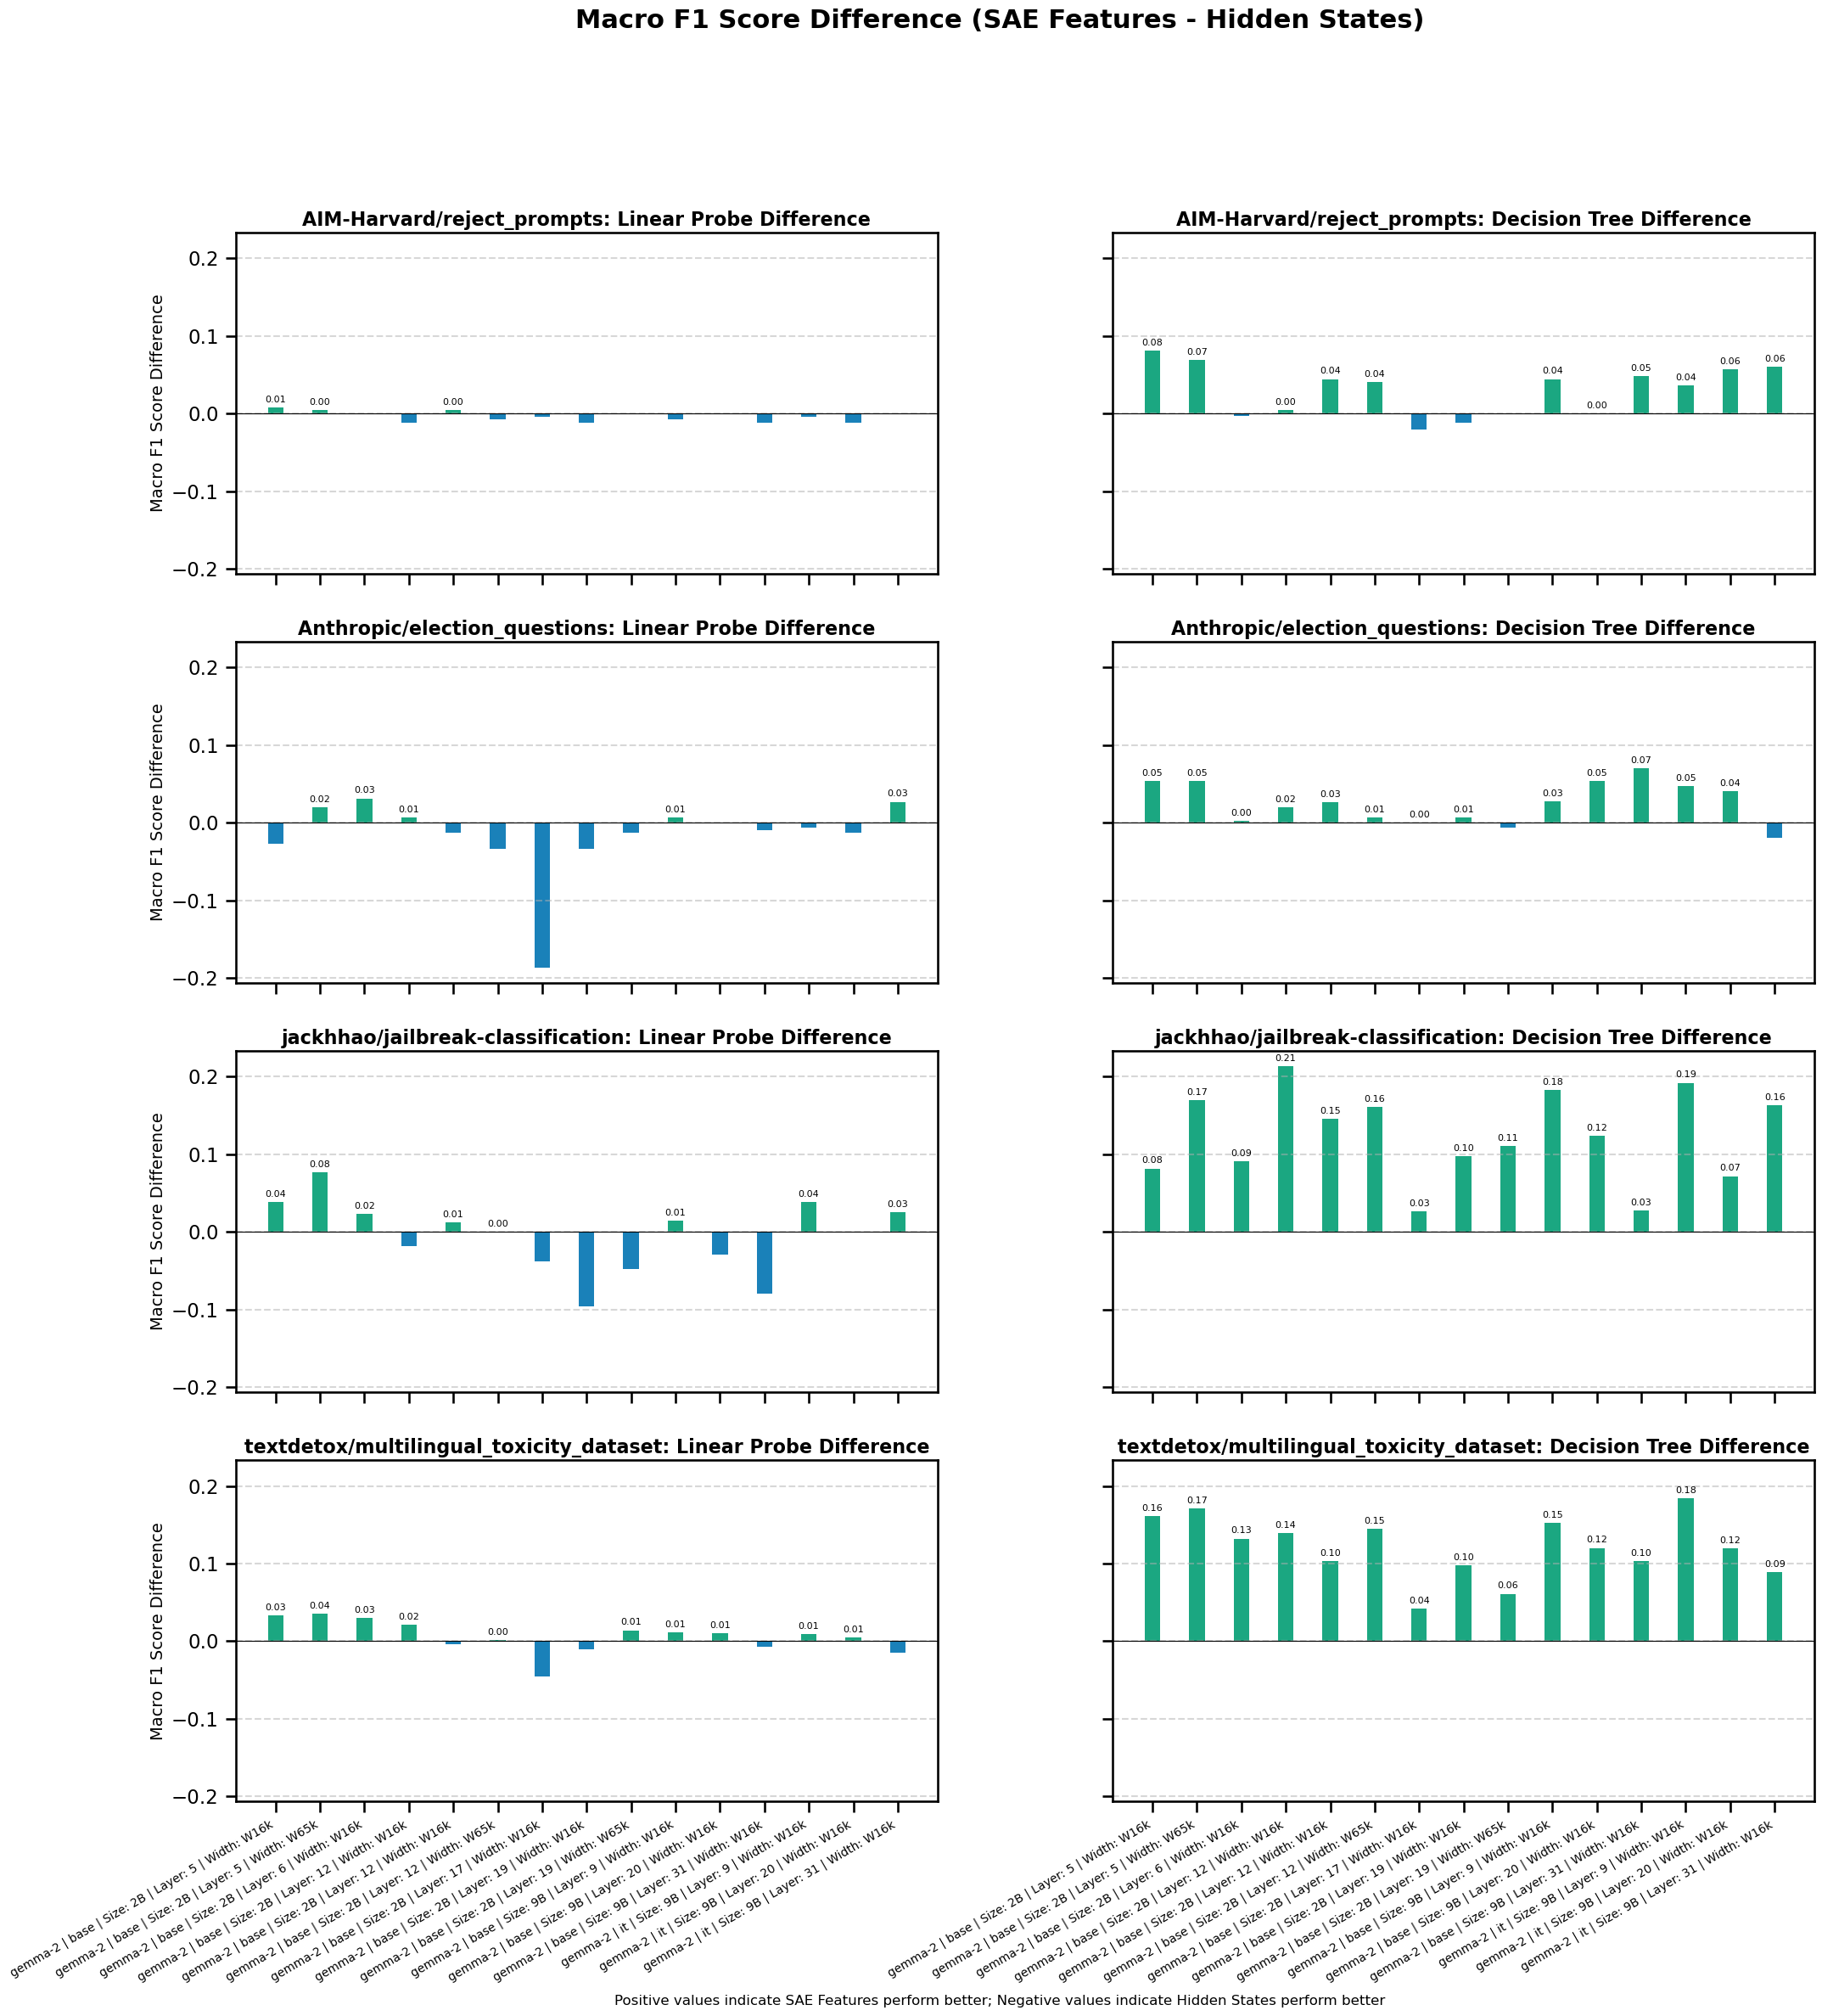

In [ ]:
# Use colorblind-friendly palette
colors = sns.color_palette("colorblind")

# Define colors for the bars
colors_hidden = colors[0]  # Hidden States color
colors_sae = colors[2]  # SAE Features color

# Create a figure with shared x-axis
fig, axes = plt.subplots(
    n_tasks,
    2,
    figsize=(24, 6 * n_tasks),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.25},
)

# Calculate the differences between SAE Features and Hidden States
merged_df_sorted["linear_macro_f1_diff"] = (
    merged_df_sorted["linear_macro_f1_score_SAE Features"]
    - merged_df_sorted["linear_macro_f1_score_Hidden States"]
)
merged_df_sorted["decision_tree_macro_f1_diff"] = (
    merged_df_sorted["decision_tree_macro_f1_score_SAE Features"]
    - merged_df_sorted["decision_tree_macro_f1_score_Hidden States"]
)


# Loop through tasks
for i, task in enumerate(tasks):
    task_df = merged_df_sorted[merged_df_sorted["dataset_name"] == task]
    task_df = task_df.reset_index(drop=True)
    x_indices = np.arange(len(task_df))

    # Create detailed x-axis labels for settings
    settings = task_df[["model", "size", "type", "layer", "width"]].apply(
        lambda row: f"{row['model']} | {row['type']} | Size: {row['size']}B | Layer: {row['layer']} | Width: W{row['width']}",
        axis=1,
    )

    # Linear Probe Performance Difference
    ax1 = axes[i, 0]
    probe_diff = task_df["linear_macro_f1_diff"].fillna(0).values

    # Assign colors based on the sign of the difference
    bar_colors_probe = [colors_sae if val >= 0 else colors_hidden for val in probe_diff]

    rects1 = ax1.bar(x_indices, probe_diff, 0.35, color=bar_colors_probe, alpha=0.9)
    autolabel(ax1, rects1, fontsize=8)

    ax1.set_title(f"{task}: Linear Probe Difference", fontsize=16, weight="bold")
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    ax1.set_ylabel("Macro F1 Score Difference", fontsize=14)
    ax1.axhline(0, color="black", linewidth=0.8)

    # Decision Tree Performance Difference
    ax2 = axes[i, 1]
    tree_diff = task_df["decision_tree_macro_f1_diff"].fillna(0).values

    # Assign colors based on the sign of the difference
    bar_colors_tree = [colors_sae if val >= 0 else colors_hidden for val in tree_diff]

    rects2 = ax2.bar(x_indices, tree_diff, 0.35, color=bar_colors_tree, alpha=0.9)
    autolabel(ax2, rects2, fontsize=8)

    ax2.set_title(f"{task}: Decision Tree Difference", fontsize=16, weight="bold")
    ax2.grid(axis="y", linestyle="--", alpha=0.5)
    ax2.axhline(0, color="black", linewidth=0.8)

    # Handle x-axis labels
    if i != n_tasks - 1:
        ax1.tick_params(labelbottom=False)
        ax2.tick_params(labelbottom=False)
    else:
        ax1.set_xticks(x_indices)
        ax1.set_xticklabels(settings, rotation=30, ha="right", fontsize=10)
        ax2.set_xticks(x_indices)
        ax2.set_xticklabels(settings, rotation=30, ha="right", fontsize=10)

# Add overall title and adjust layout
fig.suptitle(
    "Macro F1 Score Difference (SAE Features - Hidden States)",
    fontsize=22,
    weight="bold",
    y=0.99,
)
fig.text(
    0.5,
    0.01,
    "Positive values indicate SAE Features perform better; Negative values indicate Hidden States perform better",
    ha="center",
    fontsize=12,
)

# Adjust layout to prevent label overlap
fig.tight_layout(rect=[0, 0.04, 1, 0.95])

# Save the figure
plt.savefig("task_f1_difference_comparison.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()